In [87]:
import pandas as pd
import os
import json
from pathlib import Path
#import matplotlib as plt
import matplotlib.pyplot as plt 


data = []
def load_json_files(directory_path):
    dir_path = Path(directory_path)

    for file_path in dir_path.glob('*.json'):
        try:
            with open(file_path, 'r') as file:
                data.append(json.load(file))
        except Exception as e:
            print(f"Error reading {file_path}: {str(e)}")

load_json_files('../../s3/triangulation_test')

In [88]:
len(data)

799

In [89]:
len([d for d in data if 'browserCoordinates' in d])

149

<Axes: xlabel='longitude', ylabel='latitude'>

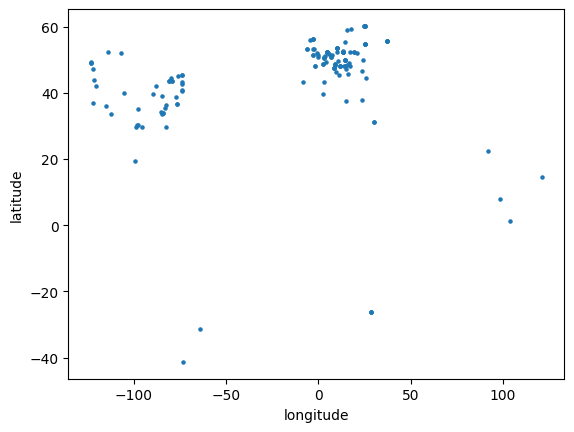

In [90]:
pd.DataFrame([d['browserCoordinates'] for d in data if 'browserCoordinates' in d]).plot.scatter(x='longitude', y='latitude', s=5)

In [91]:
pd.DataFrame([j for i in data[0]['measurementRounds'] for j in i['inferredData']['latencies']]).groupby(by='region').min()

,value
region,
af-south-1,120.0
ap-northeast-1,138.5
ap-south-1,149.0
eu-central-1,64.0
eu-west-1,43.5
sa-east-1,108.5
us-east-1,64.0
us-west-2,115.0


In [92]:
with_coords = [i for i in data if 'browserCoordinates' in i]

In [93]:
df = pd.DataFrame([
    {
        'latitude': x['browserCoordinates']['latitude'],
        'longitude': x['browserCoordinates']['longitude'],
        'region': i['region'],
        'latency': i['value']
    }
    for x in with_coords
    for j in x['measurementRounds']
    for i in j['inferredData']['latencies']
])
df

,latitude,longitude,region,latency
0,51.997876,-0.750706,us-east-1,77.0
1,51.997876,-0.750706,eu-west-1,82.0
2,51.997876,-0.750706,eu-central-1,88.0
3,51.997876,-0.750706,us-west-2,311.5
4,51.997876,-0.750706,sa-east-1,366.5
...,...,...,...,...
3571,48.414901,15.616889,us-west-2,119.0
3572,48.414901,15.616889,sa-east-1,152.0
3573,48.414901,15.616889,ap-south-1,105.0
3574,48.414901,15.616889,ap-northeast-1,180.5


Text(0.5, 1.0, 'Actual longitude vs. latency to US(Oregon)')

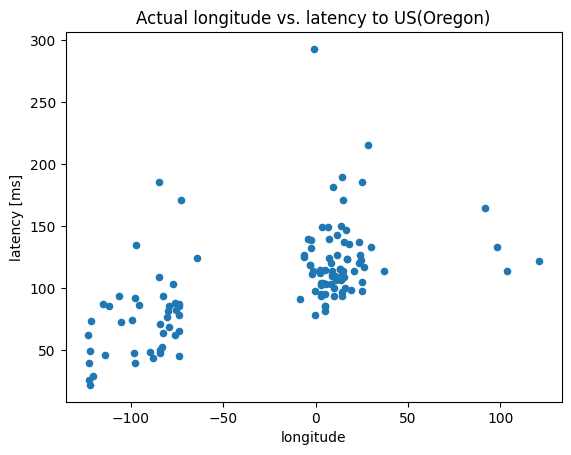

In [94]:
df_2 = df.groupby(by=['latitude', 'longitude', 'region']).min().reset_index()

df_2[df_2.region == 'us-west-2'].plot.scatter(x='longitude', y='latency')
ax = plt.gca()
ax.set_ylabel('latency [ms]')
ax.set_title('Actual longitude vs. latency to US(Oregon)')

Text(0.5, 1.0, 'Actual longitude vs. latency to DE(Frankfurt)')

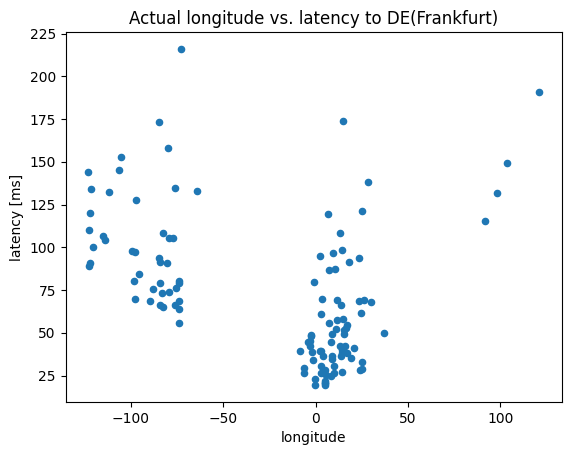

In [95]:
df_2[df_2.region == 'eu-west-1'].plot.scatter(x='longitude', y='latency')
ax = plt.gca()
ax.set_ylabel('latency [ms]')
ax.set_title('Actual longitude vs. latency to DE(Frankfurt)')

/var/folders/xg/dycs1zvj1lgffxn_sm9wfx980000gn/T/ipykernel_14880/1324729916.py:82: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  region_df['lat_bin'] = pd.cut(region_df['latitude'], bins=lat_bins, labels=lat_bins[:-1])
/var/folders/xg/dycs1zvj1lgffxn_sm9wfx980000gn/T/ipykernel_14880/1324729916.py:83: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  region_df['lon_bin'] = pd.cut(region_df['longitude'], bins=lon_bins, labels=lon_bins[:-1])
/var/folders/xg/dycs1zvj1lgffxn_sm9wfx980000gn/T/ipykernel_14880/13247299

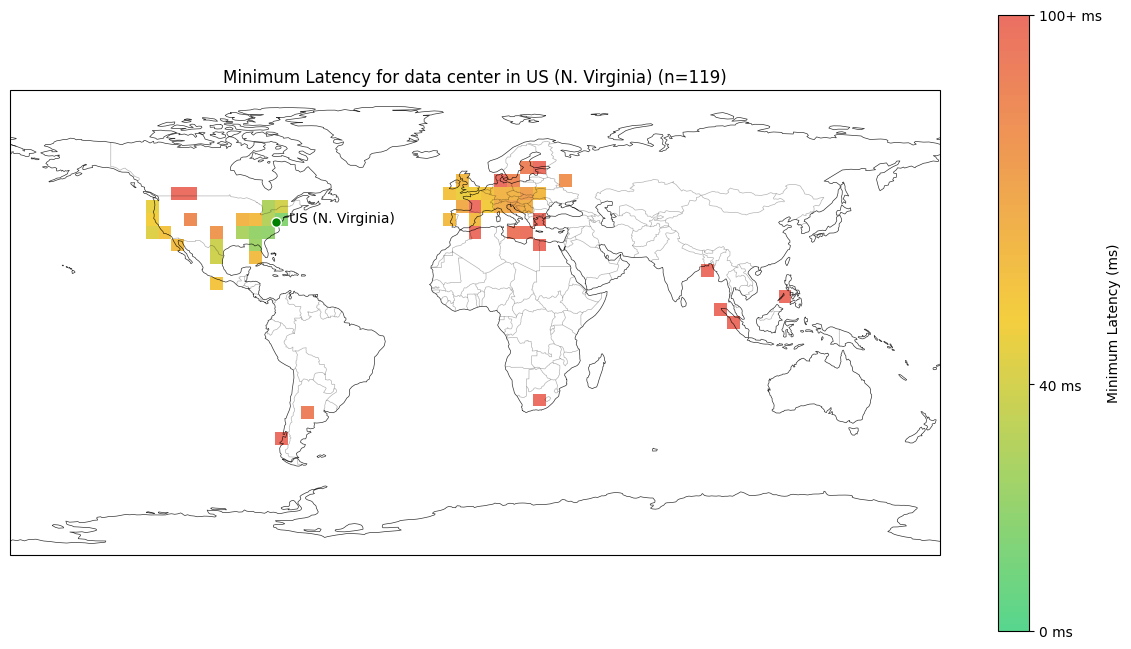

In [99]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import cartopy.feature as cfeature
import cartopy.crs as ccrs
from matplotlib.colors import LinearSegmentedColormap


dataCenters = [
  {
    'name': 'Frankfurt',
    'name_long': 'eu-central-1',
    'coordinates': [8.6821, 50.1109], 
    'url': 'https://wpbwaytwexqulyjlmly3rjkkdu0thgrr.lambda-url.eu-central-1.on.aws/',
    'color': '#FF6B6B'
  },
  {
    'name': 'Tokyo',
    'name_long': 'ap-northeast-1',
    'coordinates': [139.7594, 35.6850], 
    'url': 'https://hhhauh3i652elinvl7b37vh2ma0nrujk.lambda-url.ap-northeast-1.on.aws/',
    'color': '#FF006E'
  },
  {
    'name': 'São Paulo',
    'name_long': 'sa-east-1',
    'coordinates': [-46.6333, -23.5505],
    'url': 'https://unw3gvztdtl64g4zbzuyo6rozi0cvulu.lambda-url.sa-east-1.on.aws/',
    'color': '#45B7D1'
  },
  {
    'name': 'US (N. Virginia)',
    'name_long': 'us-east-1',
    'coordinates': [-77.0469, 38.8048], 
    'url': 'https://2snia32ceolmfhv45btw62rep40sfndz.lambda-url.us-east-1.on.aws/',
    'color': '#FFBE0B'
  },
  {
    'name': 'US (Oregon)',
    'name_long': 'us-west-2',
    'coordinates': [-122.6765, 45.5231],
    'url': 'https://22kcgok5hkce3srzl4xksadj740npzoo.lambda-url.us-west-2.on.aws/',
    'color': '#88D8B0'
  },
  {
    'name': 'Mumbai',
    'name_long': 'ap-south-1',
    'coordinates': [72.8777, 19.0760], 
    'url': 'https://rchgdkidnerk2gkfiynfgkveje0iujmm.lambda-url.ap-south-1.on.aws/',
    'color': '#96CEB4'
  },
  {
    'name': 'Dublin',
    'name_long': 'eu-west-1',
    'coordinates': [-6.2603, 53.3498],
    'url': 'https://5xaynesucez2tdtndxuyyqmjei0txpcw.lambda-url.eu-west-1.on.aws/',
    'color': '#4ECDC4'
  },
  {
    'name': 'Cape Town',
    'name_long': 'af-south-1',
    'coordinates': [18.4241, -33.9249],
    'url': 'https://bcjj76sx7xfqoz6yc6ngw6ioma0ajqsb.lambda-url.af-south-1.on.aws/',
    'color': '#8338EC'
  }
]

def create_latency_heatmap(df, selected_region):
    # Filter data for selected region
    region_df = df[df['region'] == selected_region]
    
    # Get data center info and number of measurements
    dc_info = next(dc for dc in dataCenters if dc['name_long'] == selected_region)
    n_measurements = len(region_df.apply(lambda x: str(x['longitude']) + str(x['latitude']), axis=1).drop_duplicates())
    
    # Create bins for latitude and longitude (5 degree squares)
    lat_bins = np.arange(-90, 91, 5)
    lon_bins = np.arange(-180, 181, 5)
    
    # Bin the coordinates
    region_df['lat_bin'] = pd.cut(region_df['latitude'], bins=lat_bins, labels=lat_bins[:-1])
    region_df['lon_bin'] = pd.cut(region_df['longitude'], bins=lon_bins, labels=lon_bins[:-1])
    
    # Calculate minimum latency for each grid square
    grid_data = region_df.groupby(['lat_bin', 'lon_bin'])['latency'].min().reset_index()
    
    # Create a pivot table for the heatmap
    heatmap_data = grid_data.pivot(index='lat_bin', columns='lon_bin', values='latency')
    
    # Create the plot with cartopy projection
    fig = plt.figure(figsize=(15, 8))
    ax = plt.axes(projection=ccrs.PlateCarree())
    
    # Add coastlines and borders
    ax.add_feature(cfeature.COASTLINE, linewidth=0.5, alpha=0.8)
    ax.add_feature(cfeature.BORDERS, linewidth=0.5, alpha=0.3)
    
    # Create custom colormap with transition at 40ms
    colors = ['#2ecc71', '#f1c40f', '#e74c3c']  # green, yellow, red
    n_bins = 100
    cmap = LinearSegmentedColormap.from_list('custom', colors, N=n_bins)
    norm = plt.Normalize(vmin=0, vmax=100)
    
    # Plot the heatmap
    plt.pcolormesh(lon_bins[:-1], lat_bins[:-1], 
                   heatmap_data.values, 
                   cmap=cmap,
                   norm=norm,
                   transform=ccrs.PlateCarree(),
                   alpha=0.8)
    
    # Add colorbar with custom ticks
    cbar = plt.colorbar(label='Minimum Latency (ms)')
    cbar.set_ticks([0, 40, 100])
    cbar.set_ticklabels(['0 ms', '40 ms', '100+ ms'])
    
    # Set title and labels
    plt.title(f'Minimum Latency for data center in {dc_info["name"]} (n={n_measurements})')
    ax.set_xlabel('Longitude (°)')
    ax.set_ylabel('Latitude (°)')
    
    # Set global extent
    ax.set_global()
    
    # Add data center marker
    plt.plot(dc_info['coordinates'][0], dc_info['coordinates'][1], 
             marker='o', color='green', 
             markersize=7, markeredgecolor='white',
             transform=ccrs.PlateCarree())
    
    # Add label for the data center
    plt.text(dc_info['coordinates'][0] + 5, dc_info['coordinates'][1], 
             dc_info['name'], color='black', fontweight='normal',
             transform=ccrs.PlateCarree())
    
    plt.show()

# Example usage
create_latency_heatmap(df, 'us-east-1')



/var/folders/xg/dycs1zvj1lgffxn_sm9wfx980000gn/T/ipykernel_14880/1324729916.py:82: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  region_df['lat_bin'] = pd.cut(region_df['latitude'], bins=lat_bins, labels=lat_bins[:-1])
/var/folders/xg/dycs1zvj1lgffxn_sm9wfx980000gn/T/ipykernel_14880/1324729916.py:83: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  region_df['lon_bin'] = pd.cut(region_df['longitude'], bins=lon_bins, labels=lon_bins[:-1])
/var/folders/xg/dycs1zvj1lgffxn_sm9wfx980000gn/T/ipykernel_14880/13247299

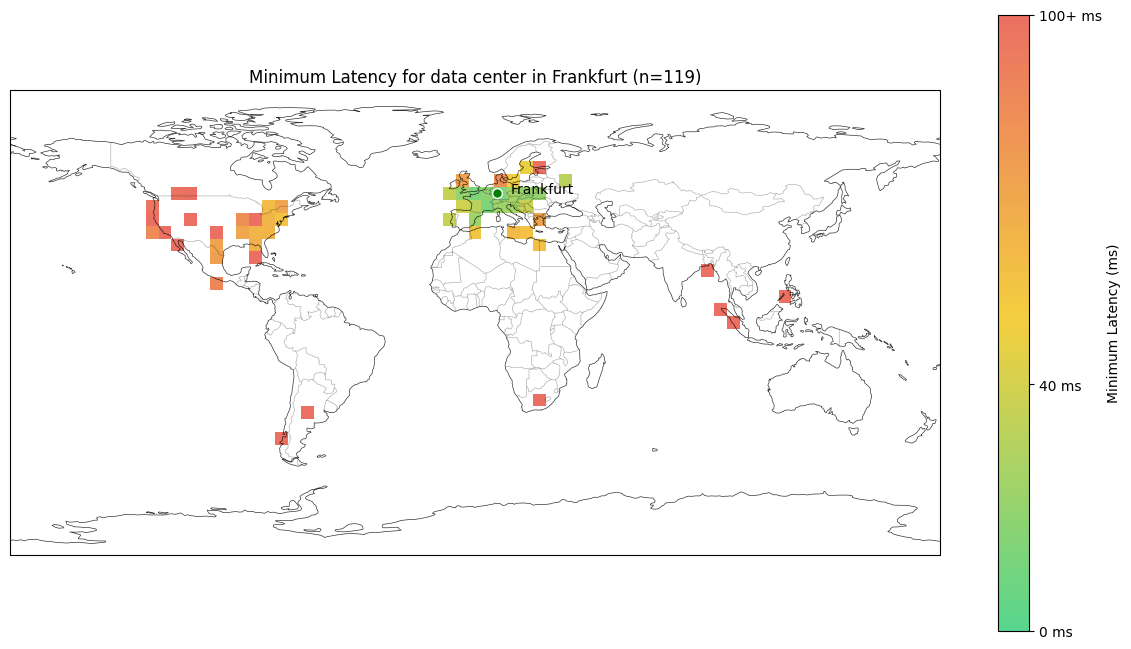

In [100]:
create_latency_heatmap(df, 'eu-central-1')
